In [31]:
import torch 
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import math 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 

In [3]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_size, hidden_sizes[0])
        self.relu_0 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu_1 = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, X):
        model = self.input(X)
        model = self.relu_0(model)
        model = self.hidden1(model)
        model = self.relu_1(model)
        model = self.output(model)
        return model 

In [4]:
batch_size = 50
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False , num_workers=2)

In [5]:
model = torch.load('digit_classifier.pt')
model.eval()

DigitRecognizer(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (relu_0): ReLU()
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (relu_1): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [69]:
def eval_model(model, images):
    # images, labels are batches of 50
    images = images.reshape(-1, 784)
    outputs = model(images) 

    _, test_predicted = torch.max(outputs.data,1)
    return test_predicted.item()

#adversarial criterion is untargeted
def generate_initial_adverarial(targeted_class, model, fn):
    while True: 
        adversarial = np.random.randint(low = 0, high = 255, size = (1,28,28))
        model_output = fn(model, torch.tensor(adversarial, dtype = torch.float32))
        if model_output != targeted_class: 
            return adversarial

def is_adversarial(perturbed_image, targeted_class, fn, model):
    model_output = fn(model, torch.tensor(perturbed_image, dtype = torch.float32))
    if model_output != targeted_class: 
        return True
    return False


def sample_proposal_dist(original_image, prev_image, shape, delta):
    new_pertubation = np.random.normal(size = shape)
    # normalize the pertubation
    new_pertubation /= np.linalg.norm(new_pertubation.reshape(28,28), 2)
    # scale its l2 norm as follows: ||n_k||_2 = delta * d(0,0^k-1)
    new_pertubation *= delta * np.linalg.norm(original_image - prev_image)
    perturbed_image = new_pertubation + prev_image
    # condition 1, new_pertubation +  prev_image in [0,255]
    perturbed_image = np.clip(perturbed_image, 0, 255)
    return perturbed_image

#The distance between points is defined as the norm of their difference.
def project_onto_sphere(original_image, prev_pertubation, new_pertubation, radius):
    # make position relative to coordinates of image
    recentered = (new_pertubation - original_image).astype(np.float32)
    dist_recentered = np.linalg.norm(recentered)
    # normalize the image
    recentered /= dist_recentered
    recentered *= radius
    #clip the image 
    new_perturbed_image = np.clip(original_image + recentered, 0, 255)
    return new_perturbed_image

# d(0,0^k-1) - d(0,0^k-1 + n^k) =  epsilon d(0,0^k-1)
def step_towards(original_image, perturbed_image, epsilon):
    return (original_image - perturbed_image).astype(np.float32) * epsilon

def generate_new_adversarial_image(delta, target_image, n_k):
    temp = (target_image - n_k).astype(np.float32)
    radius = np.linalg.norm(temp)
    new_pertubation = sample_proposal_dist(target_image, n_k, (1,28,28), delta)
    new_pertubation = project_onto_sphere(target_image, n_k, new_pertubation, radius)
    return new_pertubation

        
def boundary_attack(model, model_eval, target_class, target_image, maximum_steps): 
    delta, epsilon = .1, 1.0
    target_image = target_image.detach().numpy()
    
    n_k = generate_initial_adverarial(target_class, model, eval_model)

    while True:
        temp = generate_initial_adverarial(target_class, model, eval_model)
        temp = step_towards(target_image,temp, epsilon )
        if is_adversarial(temp, target_class, eval_model, model): 
            n_k = temp
            break
        else: 
            epsilon *= .9
            

    for i in tqdm(range(maximum_steps), total = maximum_steps): 
        # take orthogonal step and adjust delta
        count = 0
        
        while True: 
            count += 1
            avg_orthogonal =\
            np.mean([is_adversarial( generate_new_adversarial_image(delta, target_image, 
                                                                       n_k), \
                              target_class, eval_model, model) for i in range(10)])

            print(f'{delta = }, {count =}')
            print(f'{avg_orthogonal=}')
            if avg_orthogonal == 1: 
                 delta /= .001
            elif avg_orthogonal < .4: 
                delta *= .9
            elif avg_orthogonal > .6:  #avg_orthogonal > .5:
                delta *= 1.3
            else: 
                break    
            
        orthogonal_step = generate_new_adversarial_image(delta, target_image, n_k)
        
        # take step towards image step and adjust epsilon
        # try to achieve a ratio of .5, to produce a linear boundary between regions
        count = 0
        while True: 
            count += 1
            avg_step_twds =\
            np.mean([is_adversarial(step_towards(target_image, orthogonal_step, epsilon), 
                                    target_class, eval_model, model) for i in range(10)])

            print(f'{epsilon = }, {count=}')
            print(f'{avg_step_twds=}')
            if avg_step_twds < .4: 
                epsilon /= 2
            elif avg_step_twds > .6:  #avg_orthogonal > .5:
                epsilon *= 1.15
            else: 
                break
            
        if is_adversarial(step_towards): 
            n_k = step_towards
        
    return n_k 

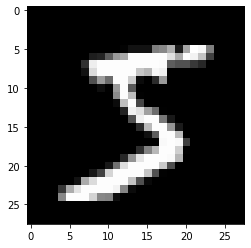

target_class=5


In [10]:
%matplotlib inline 
for a, b in train_data:
    target_img = a
    plt.imshow(target_img.reshape(28,28), cmap="gray")
    plt.show()
    target_class = eval_model(model, target_img)
    print(f'{target_class=}')
    break

In [70]:
final = boundary_attack(model, eval_model, target_class, target_img, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

delta = 0.1, count =1
avg_orthogonal=1.0
delta = 100.0, count =2
avg_orthogonal=1.0
delta = 100000.0, count =3
avg_orthogonal=1.0
delta = 100000000.0, count =4
avg_orthogonal=1.0
delta = 100000000000.0, count =5
avg_orthogonal=1.0
delta = 100000000000000.0, count =6
avg_orthogonal=1.0
delta = 1e+17, count =7
avg_orthogonal=1.0
delta = 1e+20, count =8
avg_orthogonal=1.0
delta = 1e+23, count =9
avg_orthogonal=1.0
delta = 9.999999999999999e+25, count =10
avg_orthogonal=1.0
delta = 1e+29, count =11
avg_orthogonal=0.9
delta = 1.3e+29, count =12
avg_orthogonal=1.0
delta = 1.2999999999999999e+32, count =13
avg_orthogonal=1.0
delta = 1.2999999999999998e+35, count =14
avg_orthogonal=1.0
delta = 1.2999999999999998e+38, count =15
avg_orthogonal=1.0
delta = 1.2999999999999996e+41, count =16
avg_orthogonal=1.0
delta = 1.2999999999999996e+44, count =17
avg_orthogonal=1.0
delta = 1.2999999999999996e+47, count =18
avg_orthogonal=1.0
delta = 1.2999999999999997e+50, count =19
avg_orthogonal=0.8
delta = 

/var/folders/73/tczzn7854g585r2p_1tbs9340000gn/T/ipykernel_677/2828462694.py:29: RuntimeWarning: overflow encountered in multiply
  new_pertubation *= delta * np.linalg.norm(original_image - prev_image)



avg_orthogonal=1.0
delta = inf, count =138
avg_orthogonal=1.0
delta = inf, count =139
avg_orthogonal=1.0
delta = inf, count =140
avg_orthogonal=1.0
delta = inf, count =141
avg_orthogonal=1.0
delta = inf, count =142
avg_orthogonal=1.0
delta = inf, count =143
avg_orthogonal=1.0
delta = inf, count =144
avg_orthogonal=1.0
delta = inf, count =145
avg_orthogonal=1.0
delta = inf, count =146
avg_orthogonal=1.0
delta = inf, count =147
avg_orthogonal=1.0
delta = inf, count =148
avg_orthogonal=0.9
delta = inf, count =149
avg_orthogonal=1.0
delta = inf, count =150
avg_orthogonal=0.9
delta = inf, count =151
avg_orthogonal=1.0
delta = inf, count =152
avg_orthogonal=1.0
delta = inf, count =153
avg_orthogonal=0.9
delta = inf, count =154
avg_orthogonal=1.0
delta = inf, count =155
avg_orthogonal=1.0
delta = inf, count =156
avg_orthogonal=0.9
delta = inf, count =157
avg_orthogonal=1.0
delta = inf, count =158
avg_orthogonal=1.0
delta = inf, count =159
avg_orthogonal=1.0
delta = inf, count =160
avg_orthog

delta = inf, count =341
avg_orthogonal=1.0
delta = inf, count =342
avg_orthogonal=1.0
delta = inf, count =343
avg_orthogonal=1.0
delta = inf, count =344
avg_orthogonal=1.0
delta = inf, count =345
avg_orthogonal=1.0
delta = inf, count =346
avg_orthogonal=1.0
delta = inf, count =347
avg_orthogonal=1.0
delta = inf, count =348
avg_orthogonal=1.0
delta = inf, count =349
avg_orthogonal=1.0
delta = inf, count =350
avg_orthogonal=1.0
delta = inf, count =351
avg_orthogonal=1.0
delta = inf, count =352
avg_orthogonal=1.0
delta = inf, count =353
avg_orthogonal=1.0
delta = inf, count =354
avg_orthogonal=0.9
delta = inf, count =355
avg_orthogonal=1.0
delta = inf, count =356
avg_orthogonal=1.0
delta = inf, count =357
avg_orthogonal=1.0
delta = inf, count =358
avg_orthogonal=1.0
delta = inf, count =359
avg_orthogonal=1.0
delta = inf, count =360
avg_orthogonal=0.9
delta = inf, count =361
avg_orthogonal=1.0
delta = inf, count =362
avg_orthogonal=1.0
delta = inf, count =363
avg_orthogonal=1.0
delta = inf

delta = inf, count =541
avg_orthogonal=1.0
delta = inf, count =542
avg_orthogonal=0.9
delta = inf, count =543
avg_orthogonal=1.0
delta = inf, count =544
avg_orthogonal=0.9
delta = inf, count =545
avg_orthogonal=1.0
delta = inf, count =546
avg_orthogonal=1.0
delta = inf, count =547
avg_orthogonal=1.0
delta = inf, count =548
avg_orthogonal=0.9
delta = inf, count =549
avg_orthogonal=1.0
delta = inf, count =550
avg_orthogonal=1.0
delta = inf, count =551
avg_orthogonal=1.0
delta = inf, count =552
avg_orthogonal=1.0
delta = inf, count =553
avg_orthogonal=0.9
delta = inf, count =554
avg_orthogonal=1.0
delta = inf, count =555
avg_orthogonal=0.9
delta = inf, count =556
avg_orthogonal=1.0
delta = inf, count =557
avg_orthogonal=1.0
delta = inf, count =558
avg_orthogonal=1.0
delta = inf, count =559
avg_orthogonal=0.9
delta = inf, count =560
avg_orthogonal=0.9
delta = inf, count =561
avg_orthogonal=1.0
delta = inf, count =562
avg_orthogonal=0.9
delta = inf, count =563
avg_orthogonal=0.9
delta = inf

delta = inf, count =755
avg_orthogonal=0.8
delta = inf, count =756
avg_orthogonal=1.0
delta = inf, count =757
avg_orthogonal=1.0
delta = inf, count =758
avg_orthogonal=1.0
delta = inf, count =759
avg_orthogonal=1.0
delta = inf, count =760
avg_orthogonal=1.0
delta = inf, count =761
avg_orthogonal=1.0
delta = inf, count =762
avg_orthogonal=1.0
delta = inf, count =763
avg_orthogonal=0.9
delta = inf, count =764
avg_orthogonal=1.0
delta = inf, count =765
avg_orthogonal=1.0
delta = inf, count =766
avg_orthogonal=1.0
delta = inf, count =767
avg_orthogonal=1.0
delta = inf, count =768
avg_orthogonal=1.0
delta = inf, count =769
avg_orthogonal=0.9
delta = inf, count =770
avg_orthogonal=1.0
delta = inf, count =771
avg_orthogonal=1.0
delta = inf, count =772
avg_orthogonal=1.0
delta = inf, count =773
avg_orthogonal=0.9
delta = inf, count =774
avg_orthogonal=1.0
delta = inf, count =775
avg_orthogonal=1.0
delta = inf, count =776
avg_orthogonal=0.8
delta = inf, count =777
avg_orthogonal=1.0
delta = inf

delta = inf, count =962
avg_orthogonal=0.9
delta = inf, count =963
avg_orthogonal=1.0
delta = inf, count =964
avg_orthogonal=1.0
delta = inf, count =965
avg_orthogonal=1.0
delta = inf, count =966
avg_orthogonal=1.0
delta = inf, count =967
avg_orthogonal=1.0
delta = inf, count =968
avg_orthogonal=1.0
delta = inf, count =969
avg_orthogonal=1.0
delta = inf, count =970
avg_orthogonal=1.0
delta = inf, count =971
avg_orthogonal=0.9
delta = inf, count =972
avg_orthogonal=1.0
delta = inf, count =973
avg_orthogonal=0.9
delta = inf, count =974
avg_orthogonal=0.9
delta = inf, count =975
avg_orthogonal=1.0
delta = inf, count =976
avg_orthogonal=1.0
delta = inf, count =977
avg_orthogonal=1.0
delta = inf, count =978
avg_orthogonal=1.0
delta = inf, count =979
avg_orthogonal=1.0
delta = inf, count =980
avg_orthogonal=1.0
delta = inf, count =981
avg_orthogonal=1.0
delta = inf, count =982
avg_orthogonal=1.0
delta = inf, count =983
avg_orthogonal=1.0
delta = inf, count =984
avg_orthogonal=1.0
delta = inf

KeyboardInterrupt: 